# Statistical inference

We will use the data and model approach we have finalized to infer built-up land cover on the enter time period of 2016 through 2019.

## Fit model

This just executes the code to integrate our data and train our model (with the "optimal" final hyperparameters) as we developed previously:

In [1]:
import geemap, ee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# define some functions and variables
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)


se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

# create training data
roi = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME','Bagmati')).geometry()

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median().select(se2bands).clip(roi)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2019-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)

fused = se2.addBands(viirs)

# create and overlay labels to training data
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# fit classifier on entire dataset
new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}
clf = ee.Classifier.smileRandomForest(**new_params).train(data, label, trainingbands)

## Prep new data

In order to predict the data we need to prep (including fuse) the unseen data just as we did with the training data, but we'll do this for each year.

For the scope of this excercise, we're doing this at an annual level, but you could do this to produce a monthly time series. Try it yourself!

In [2]:
def img_prep(se2collection,
            viirscollection,
            year,
            se2bands,
            roi,
            se2maskfunc,
            scaleFactor):
    se2 = se2collection.filterDate(f"{year}-01-01",f"{year}-12-31").filterBounds(roi).filter(
        ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2maskfunc).median().select(se2bands).clip(roi)
    
    viirs = viirscollection.filterDate(
        f"{year}-01-01",f"{year}-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)
    return se2.addBands(viirs)

## Run inference on all years (2016-2019)

In [3]:
allyears = []

for year in ['2016','2017','2018','2019']:
    img = img_prep(se2collection=ee.ImageCollection('COPERNICUS/S2'),
                    viirscollection=ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG"),
                    year=year,
                    se2bands=se2bands,
                    roi=roi,
                    se2maskfunc=se2mask,
                    scaleFactor=scaleFactor)
    allyears.append(img.classify(clf))

## Plotting trends

We can plot histograms {doc}`mod4_2_histograms` or time series {doc}`mod4_1_time_series_charts` as you've learned.

But since our values are binary and we are comparing just a few years, a simple bar graph will do. 

If you produce a monthly time series, you might try some other plots.

As with our data structure transformations in those earlier modules mentioned (refer to them for a refresher), extracting our data into a numerical array that we can plot takes a couple steps. We'll do this for each year we have predicted data.

In [4]:
allyears_arrs = [img.sample(region=roi, scale=scaleFactor, numPixels=1000) for img in allyears]
allyears_arrs = [np.asarray(arr.reduceColumns(ee.Reducer.toList(1), 
                                              ['classification']).values().get(0).getInfo()) for arr in allyears_arrs]

Now we'll transform this to a Pandas dataframe for convenience and visualization.

Note that our dataframe across all years will have some missing values for a few years (apparently some pixels were masked for data quality or had other issues). 

We'll drop those missing values and standardize our data so instead of a direct count of built-up pixels, we'll look at the ratio of built-up for the particular year-sample.

In [5]:
df = pd.DataFrame([arr.flatten() for arr in allyears_arrs], index=['2016','2017','2018','2019']).T
df = df/df.sum(axis=0)
df = df.melt()
df = df.dropna()
df.columns =['year','built-up ratio']

In [6]:
df.groupby('year').count()

,built-up ratio
year,
2016,709
2017,986
2018,870
2019,798


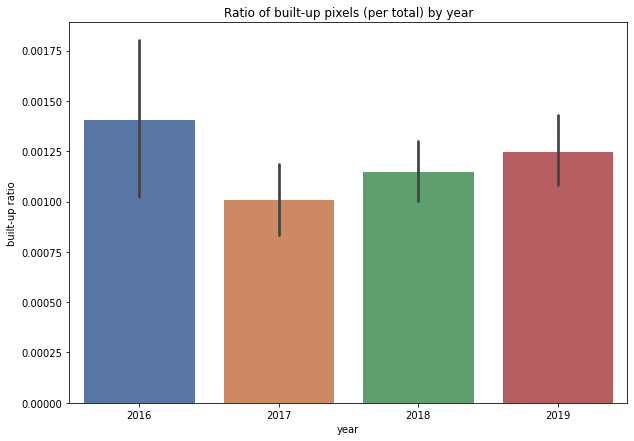

In [7]:
fig, ax = plt.subplots(1, figsize=(10,7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='year',y='built-up ratio',data=df)
plt.title('Ratio of built-up pixels (per total) by year');

We see two important things here:
- 2019 has a lower ratio of built-up land than 2016
- but 2016 seems like an outlier among a trend that is steadily growing from 2017 to 2019

Remember in our exploratory analsis when we saw bright lights East of Kathmandu? Perhaps those are an outlier in our dataset? 

It might be worth revisiting a cleaning process to improve the nighttime lights signal. 

Or maybe omit nighttime lights and see if that changes things in terms of classifier performance. 

Or try running inference on a monthly (rather than annual) time series to get more temporal information.

Or compare this to other additional provinces in Nepal (i.e. more data).

Our classifier performance had much to be improved, so extra steps may be needed to validate that before we draw any strong conclusions here.

But aside from that, is there anything we can tell right now? We might consider 2016 an outlier worth looking into, but could communicate that there does seem to be a steady growth trend from 2016 to 2019. 

We do see very large error bars in 2016 relative to the other data that justify it being an outlier. These are directly related to the sample size and as noted earlier, it is possible that data quality issues (including cloud masking?) reduced the number of observations for a given year.

## Hypothesis test

Lets conduct a t-test of means comparing 2016 and 2019 to find if this is a statistically significant difference.

We might also look at the comparison of 2017 and 2019 to capture change in that 3 year period.

#### Change from 2016 to 2019

In [9]:
yrA = '2016'
yrB = '2019'
col = 'built-up ratio'
ttest_ind(df.loc[df['year']==yrA,col], df.loc[df['year']==yrB,col])

Ttest_indResult(statistic=0.7375073767954438, pvalue=0.4609288241930577)

We do not see a significant difference (p is well over our preset alpha=0.05). So, even though it appears there is a reduction in growth, there's too much noise to say this is significant. 

**HINT:** you can usually tell when a means t-test will fail to reject the null hypothesis when the error bars of the samples being compared overlap as they do for 2016 and 2019.

This might actually give us some relief that we are not actually saying economic growth was reduced...but the noise data indicates we should do some work to clean this as well as improve our classifier.

Ok, but how about 2017 and 2019?

In [10]:
yrA = '2017'
yrB = '2019'
col = 'built-up ratio'
ttest_ind(df.loc[df['year']==yrA,col], df.loc[df['year']==yrB,col])

Ttest_indResult(statistic=-1.8062120183704231, pvalue=0.07105388306025602)

Here again we fail to reject the null hypothesis (p > 0.05), although the comparison is cleaner (lower p).

Let's take a look at 2016 versus 2019 spatially by differencing our images.

In [11]:
# initialize our map
map1 = geemap.Map()
map1.centerObject(roi, 9)
map1.addLayer(allyears[-1].subtract(allyears[0]), {"min":-1.0, "max":1.0}, 'diff')
map1.addLayerControl()
map1

Map(center=[27.87388743003947, 85.41973735675019], controls=(WidgetControl(options=['position'], widget=HBox(c…

We see that our image is truncated (along the top) which is likely due to the re-sampling constraints (or perhaps some error in processing). This shoudlnt affect our statistical sample if it is consistent across years (it seems to be), but is an indicaton of other potential data quality issues. Even with this small region we have a lot of data to process...it is probably to much to do efficiently via Google Earth Engine. 

All that said, we do see some informative results. Maybe our means test or year-by-year summary statistics did not reveal much, but spatially we do see patterns that are unmistakeably structural related to high growth (white) along road networks. Kathmandu is noticeably "neutral" (the gray "circle" in the lower center of the province. Given that it is probably nearly all built up by 2016, it stands to reason there would not be much change in 3 years and it is quite stable.

Maybe a cluster analysis of change could identify groups of similar growth patterns spatiotemporally and give us more insight into where things are growing or declining a lot or are mostly stable.


## Concluding thoughts

We did not reject the null hypothesis and on the basis of this analysis cannot confidently say we see economic growth or decline in the Province of Bagmati from 2016 to 2019. But that certainly doesnt mean there isnt or that we dont have insights here. We see in the bar graph an upward trend from 2017 to 2019. What happens in 2020 (and will COVID-19 impacts be visible?).

Perhaps some improved data engineering can clean our signal and better identify a trend. Or with a different methodology and data we can look at a longer time series (VIIRS-DNB goes back to 2012, so maybe we can use Landsat images or other Sentinel products that have longer histories.) 

Meanwhile We do see meaninful patterns of growth spatially, particularly along major road infrastructure...perhaps a connection for you to discover: is there a relationship between road investment and economic growth and can remote sensing help to answer this?

There is much to go from here and hopefullly you have a better sense of the tools to take it to the next level.